In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')


In [85]:
df1 = pd.read_csv('AutoSleep-20200124-to-20231109.csv')
df2 = pd.read_csv('AutoSleep-20231018-to-20240415.csv')

# Convert 'fromDate' to datetime
# df1['fromDate'] = pd.to_datetime(df1['fromDate'])
# df2['fromDate'] = pd.to_datetime(df2['fromDate'])

# Filter out rows from df2 that are already in df1
df2 = df2[~df2['fromDate'].isin(df1['fromDate'])]

# Concatenate the DataFrames
df = pd.concat([df1, df2])

In [86]:
df = df.drop(['fellAsleepIn', 'SpO2Avg', 'SpO2Min', 'SpO2Max', 'respAvg', 'respMin', 'respMax',
              'tags', 'notes', 'asleepAvg7','efficiencyAvg7', 'qualityAvg7', 'deepAvg7', 'sleepBPMAvg7', 
              'dayBPMAvg7', 'wakingBPMAvg7', 'hrvAvg7','sleepHRVAvg7'], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 140
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ISO8601     1296 non-null   object 
 1   fromDate    1296 non-null   object 
 2   toDate      1296 non-null   object 
 3   bedtime     1296 non-null   object 
 4   waketime    1296 non-null   object 
 5   inBed       1296 non-null   object 
 6   awake       1296 non-null   object 
 7   sessions    1296 non-null   int64  
 8   asleep      1296 non-null   object 
 9   efficiency  1296 non-null   float64
 10  quality     1295 non-null   object 
 11  deep        1295 non-null   object 
 12  sleepBPM    1295 non-null   float64
 13  dayBPM      1130 non-null   float64
 14  wakingBPM   1294 non-null   float64
 15  hrv         1293 non-null   float64
 16  sleepHRV    1289 non-null   float64
dtypes: float64(6), int64(1), object(10)
memory usage: 182.2+ KB


In [87]:
# Datetime conversions
df['ISO8601'] = pd.to_datetime(df['ISO8601'])
df['fromDate'] = pd.to_datetime(df['fromDate'], format='%A, %b %d, %Y')
df['toDate'] = pd.to_datetime(df['toDate'], format='%A, %b %d, %Y')
df['bedtime'] = pd.to_datetime(df['bedtime']).dt.time
df['waketime'] = pd.to_datetime(df['waketime']).dt.time

df['inBed'] = pd.to_datetime(df['inBed'], format='%H:%M:%S').dt.hour + (pd.to_datetime(df['inBed'], format='%H:%M:%S').dt.minute / 60)
df['awake'] = pd.to_datetime(df['awake'], format='%H:%M:%S').dt.hour  + (pd.to_datetime(df['awake'], format='%H:%M:%S').dt.minute / 60)
df['asleep'] = pd.to_datetime(df['asleep'], format='%H:%M:%S').dt.hour  + (pd.to_datetime(df['asleep'], format='%H:%M:%S').dt.minute / 60)
df['quality'] = pd.to_datetime(df['quality'], format='%H:%M:%S').dt.hour  + (pd.to_datetime(df['quality'], format='%H:%M:%S').dt.minute / 60)
df['deep'] = pd.to_datetime(df['deep'], format='%H:%M:%S').dt.hour  + (pd.to_datetime(df['deep'], format='%H:%M:%S').dt.minute / 60)


In [88]:
# Count how many days since the date of the first record in df until today
daysPassed = (df['fromDate'].max() - df['fromDate'].min()).days

# Find the percentage of days tracked
percentage_tracked = round((len(df) / daysPassed) * 100,2)

from datetime import datetime
from dateutil.relativedelta import relativedelta

timeElapsed = relativedelta(df['fromDate'].max(), df['fromDate'].min())
timeElapsed = f"{timeElapsed.years} years, {timeElapsed.months} months, {timeElapsed.days} days"

monthsMissed = (daysPassed - len(df)) // 30
daysMissed = (daysPassed - len(df)) % 30

print(f"Percentage of days tracked: {percentage_tracked}%")
print(f'Time Elapsed: {timeElapsed}')
print(f'Time Missed: {monthsMissed} months, {daysMissed} days')


Percentage of days tracked: 83.99%
Time Elapsed: 4 years, 2 months, 22 days
Time Missed: 8 months, 7 days


In [89]:
# Rolling values
cols_to_roll = ['asleep', 'quality', 'deep', 'efficiency', 'sleepBPM', 'wakingBPM', 'hrv', 'sleepHRV']
periods = [7,15,30,90]

for col in cols_to_roll:
    for period in periods:
        df[f'{col}Roll{period}'] = df[col].rolling(window=period).mean()


In [90]:
df['qual/asleep'] = df['quality'] / df['asleep']
df['deep/asleep'] = df['deep'] / df['asleep']

In [91]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
inBed,1296.0,8.046425,1.505023,0.600000,7.216667,7.983333,8.804167,23.583333
awake,1296.0,0.797467,0.803546,0.000000,0.200000,0.566667,1.133333,5.316667
sessions,1296.0,1.030093,0.175368,1.000000,1.000000,1.000000,1.000000,3.000000
asleep,1296.0,7.248958,1.439151,0.500000,6.416667,7.283333,8.083333,21.966667
efficiency,1296.0,90.303318,9.273927,22.900000,85.600000,92.900000,97.400000,100.000000
quality,1295.0,5.130631,1.158813,0.166667,4.433333,5.166667,5.883333,14.716667
deep,1295.0,1.870515,0.986767,0.000000,1.266667,1.916667,2.516667,6.733333
sleepBPM,1295.0,55.026486,7.985203,42.000000,49.700000,52.700000,57.850000,103.100000
dayBPM,1130.0,69.449646,9.614396,45.800000,62.825000,69.250000,75.600000,101.800000
wakingBPM,1294.0,50.434621,6.320022,36.000000,47.000000,49.000000,53.000000,117.000000


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 140
Data columns (total 51 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ISO8601           1296 non-null   object        
 1   fromDate          1296 non-null   datetime64[ns]
 2   toDate            1296 non-null   datetime64[ns]
 3   bedtime           1296 non-null   object        
 4   waketime          1296 non-null   object        
 5   inBed             1296 non-null   float64       
 6   awake             1296 non-null   float64       
 7   sessions          1296 non-null   int64         
 8   asleep            1296 non-null   float64       
 9   efficiency        1296 non-null   float64       
 10  quality           1295 non-null   float64       
 11  deep              1295 non-null   float64       
 12  sleepBPM          1295 non-null   float64       
 13  dayBPM            1130 non-null   float64       
 14  wakingBPM         1294 no

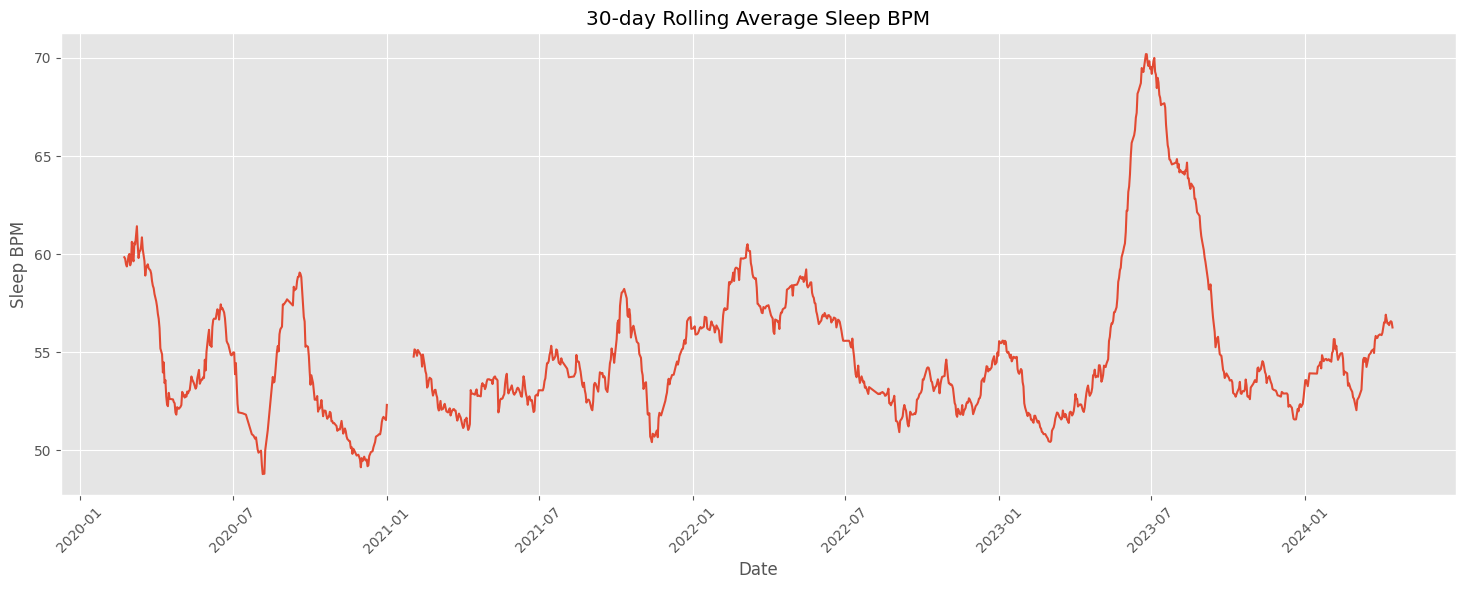

In [93]:
period = 30

plt.figure(figsize=(18,6))
plt.plot(df['fromDate'], df[f'sleepBPMRoll{period}'])
plt.title(f'{period}-day Rolling Average Sleep BPM')
plt.xlabel('Date')
plt.ylabel('Sleep BPM')
plt.xticks(rotation=45)
plt.show()


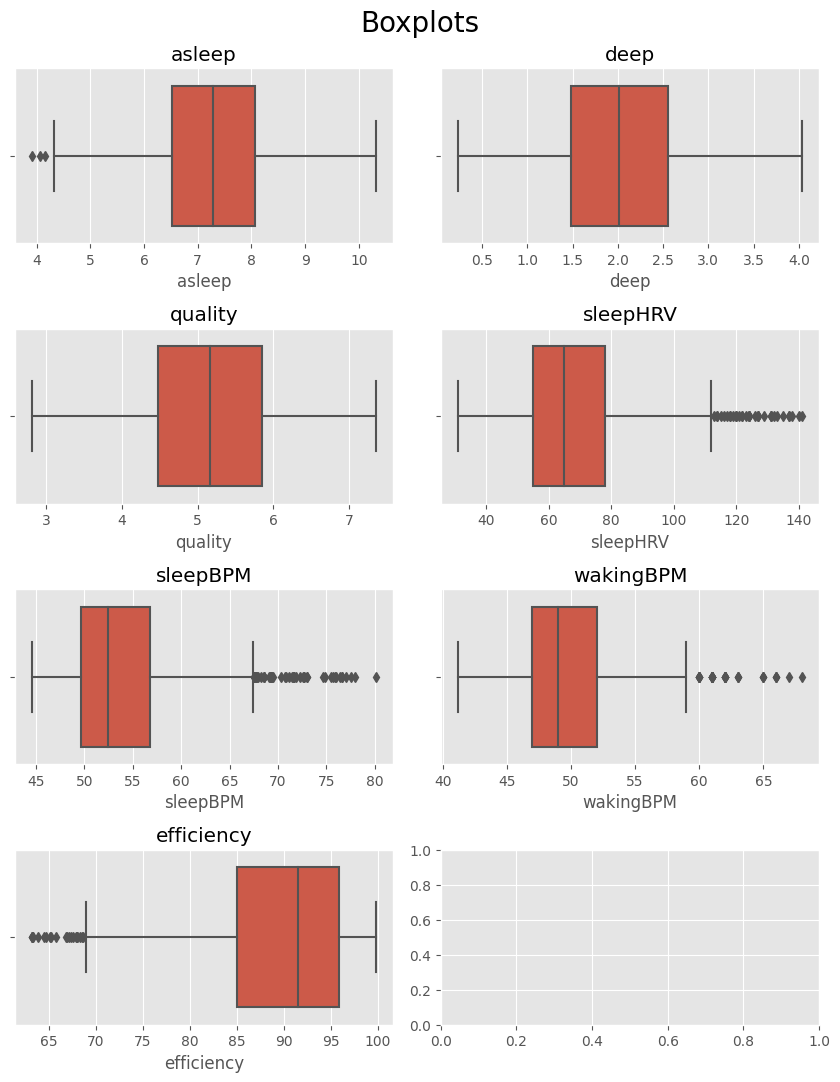

938
1296


<Figure size 640x480 with 0 Axes>

In [106]:
# Remove top and bottom 3 outlier rows for each column
df_box = df[['asleep', 'deep', 'quality', 'sleepHRV', 'sleepBPM', 'wakingBPM', 'efficiency']]
for col in df_box.columns:
    df_box = df_box[(df_box[col] > df_box[col].quantile(0.01)) & (df_box[col] < df_box[col].quantile(0.99))]

# Boxplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(8.5, 11))
plt.suptitle('Boxplots', size=20)
for i, col in enumerate(df_box.columns):
    sns.boxplot(x=col, data=df_box, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'{col}')
plt.tight_layout()
plt.show()

plt.savefig('boxplots.jpg', dpi=400)
print(len(df_box))
print(len(df))


/var/folders/y_/8cmvsg791ys9qqbzj_yxrlj40000gn/T/ipykernel_53497/2486680100.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = round(df[[col for col in df.columns if 'Roll' not in col and '/' not in col]].corr(),4)


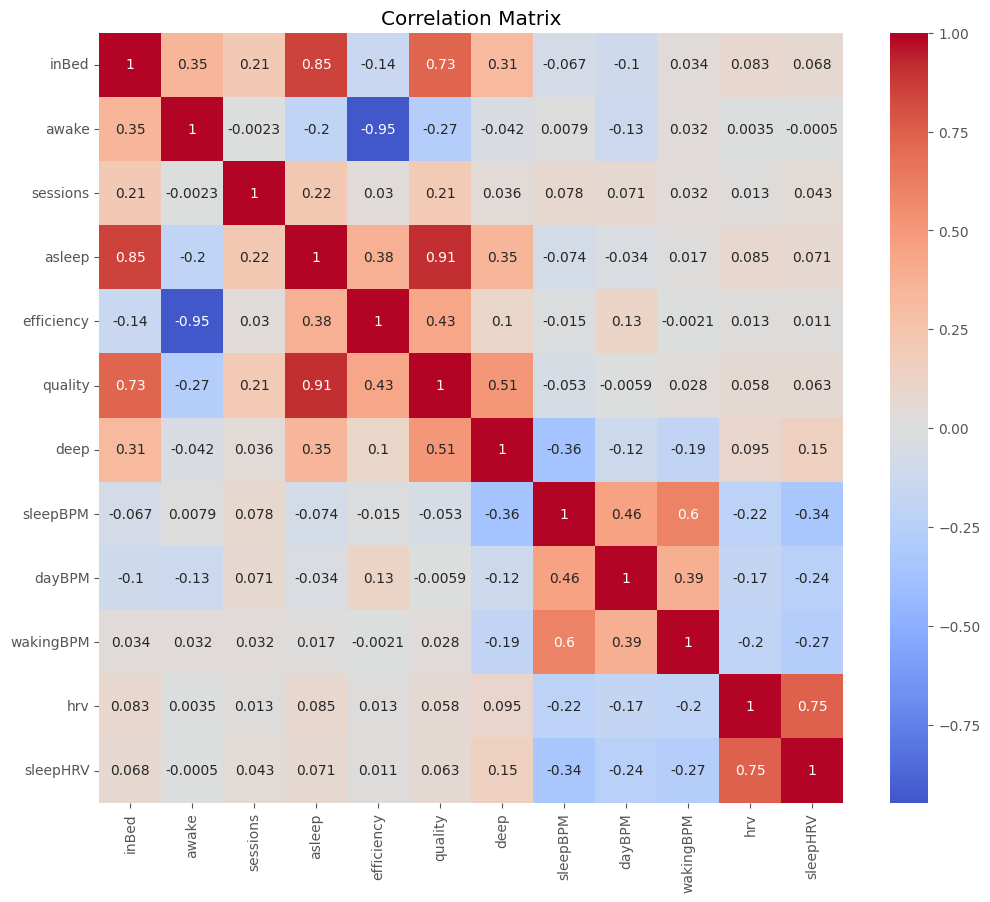

In [95]:
correlation_matrix = round(df[[col for col in df.columns if 'Roll' not in col and '/' not in col]].corr(),4)
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()


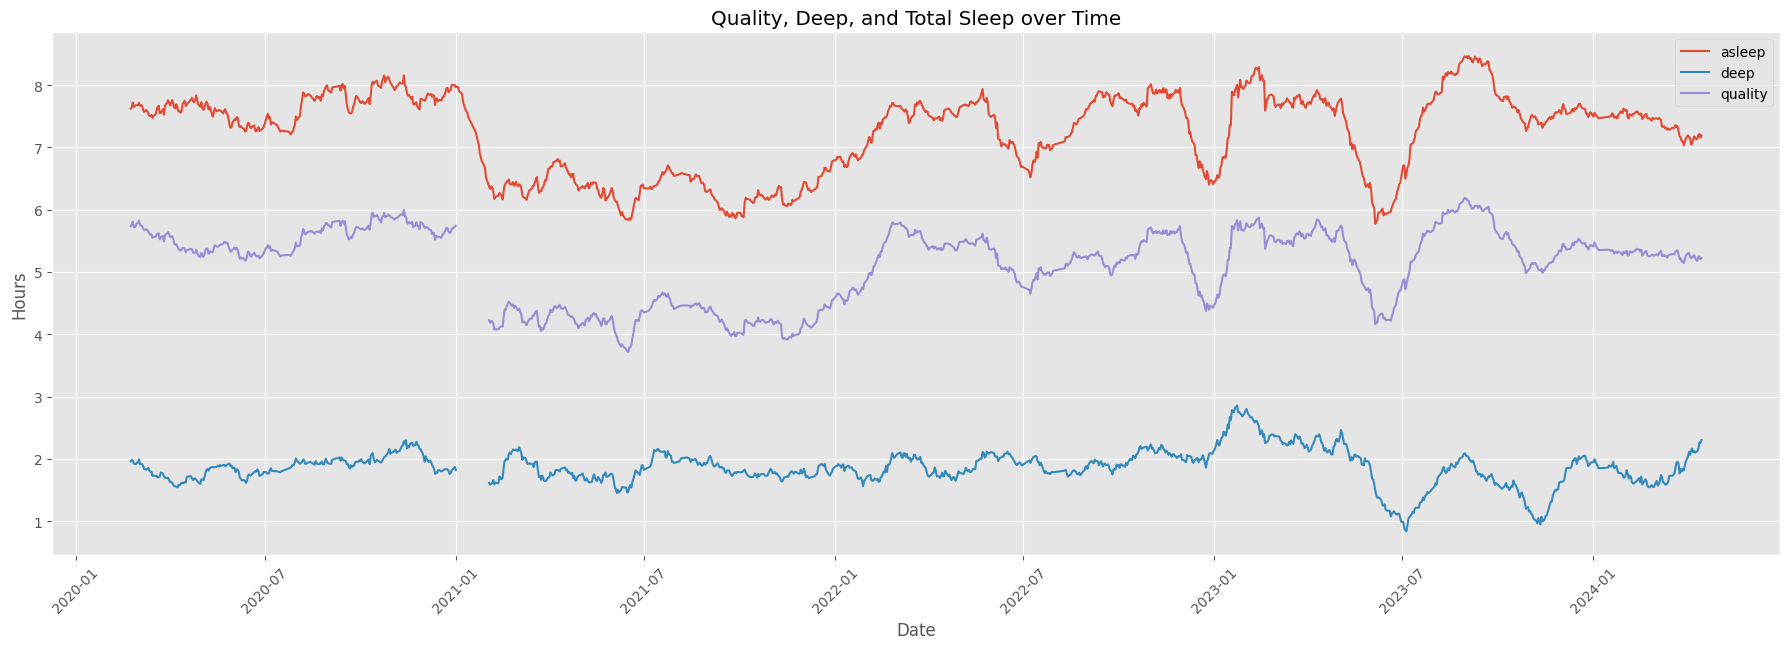

In [96]:
window = 30

fig, ax1 = plt.subplots(figsize=(18,6))

ax1.set_xlabel('Date')
ax1.set_ylabel('Hours')
ax1.plot(df['fromDate'], df['asleep'].rolling(window=window).mean(), label='asleep')
ax1.plot(df['fromDate'], df['deep'].rolling(window=window).mean(), label='deep')
ax1.plot(df['fromDate'], df['quality'].rolling(window=window).mean(), label='quality')
ax1.tick_params(axis='y')
ax1.legend()

fig.tight_layout()  
plt.title('Quality, Deep, and Total Sleep over Time')
plt.xticks(rotation=45)
plt.show()


KeyError: 'asleepAvg7'

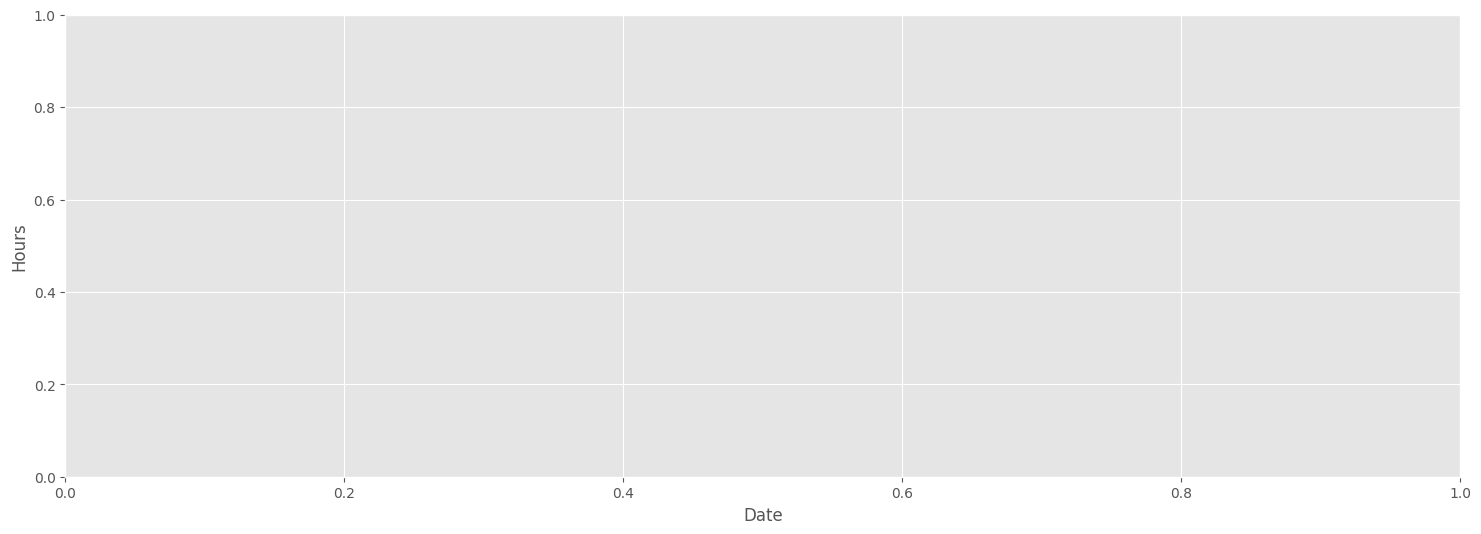

In [97]:
fig, ax1 = plt.subplots(figsize=(18,6))

ax1.set_xlabel('Date')
ax1.set_ylabel('Hours')
ax1.plot(df['fromDate'], df['asleepAvg7'], label='asleepAvg7')
ax1.plot(df['fromDate'], df['asleepRoll7'], label='asleepRoll7')
ax1.tick_params(axis='y')
ax1.legend()

fig.tight_layout()  
plt.title('Average and Rolling Asleep Time over Time')
plt.xticks(rotation=45)
plt.show()


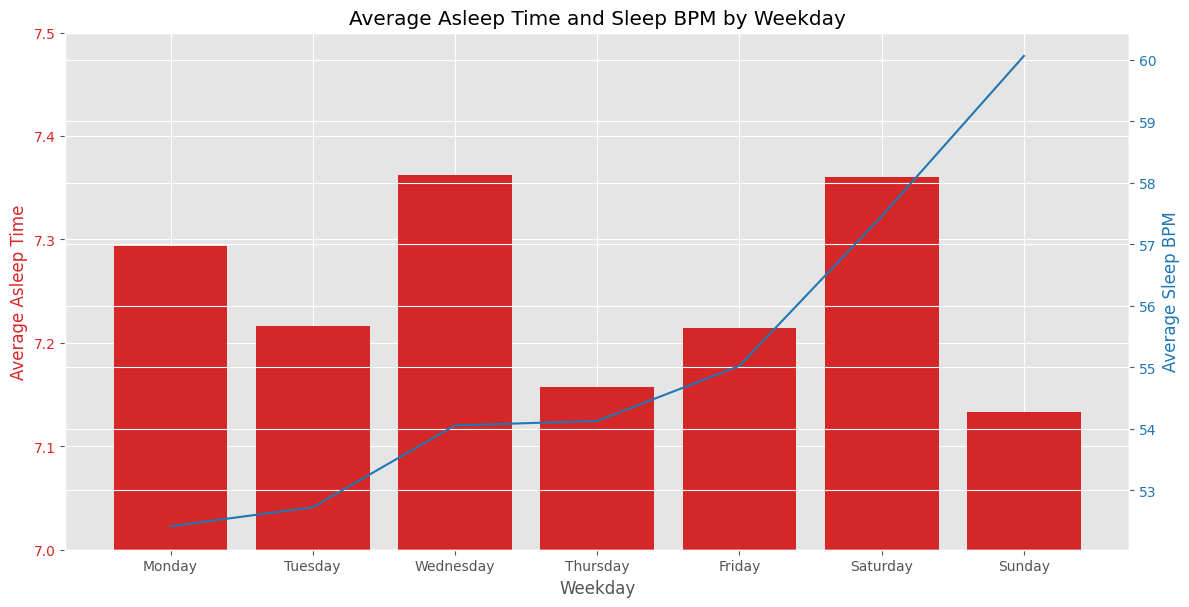

In [ ]:
df['weekday'] = df['fromDate'].dt.day_name()
df['weekday'] = pd.Categorical(df['weekday'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
df['asleep'] = df['asleep'].astype(float)
df['sleepBPM'] = df['sleepBPM'].astype(float)

df_weekday = df.groupby('weekday').agg({'asleep': 'mean', 'sleepBPM': 'mean'}).reset_index()

fig, ax1 = plt.subplots(figsize=(12,6))

color = 'tab:red'
ax1.set_xlabel('Weekday')
ax1.set_ylabel('Average Asleep Time', color=color)
ax1.bar(df_weekday['weekday'], df_weekday['asleep'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(7, 7.5)  # Set the y-axis limits to only show between 6 and 8

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Average Sleep BPM', color=color)  
ax2.plot(df_weekday['weekday'], df_weekday['sleepBPM'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Average Asleep Time and Sleep BPM by Weekday')
plt.xticks(rotation=45)
plt.show()


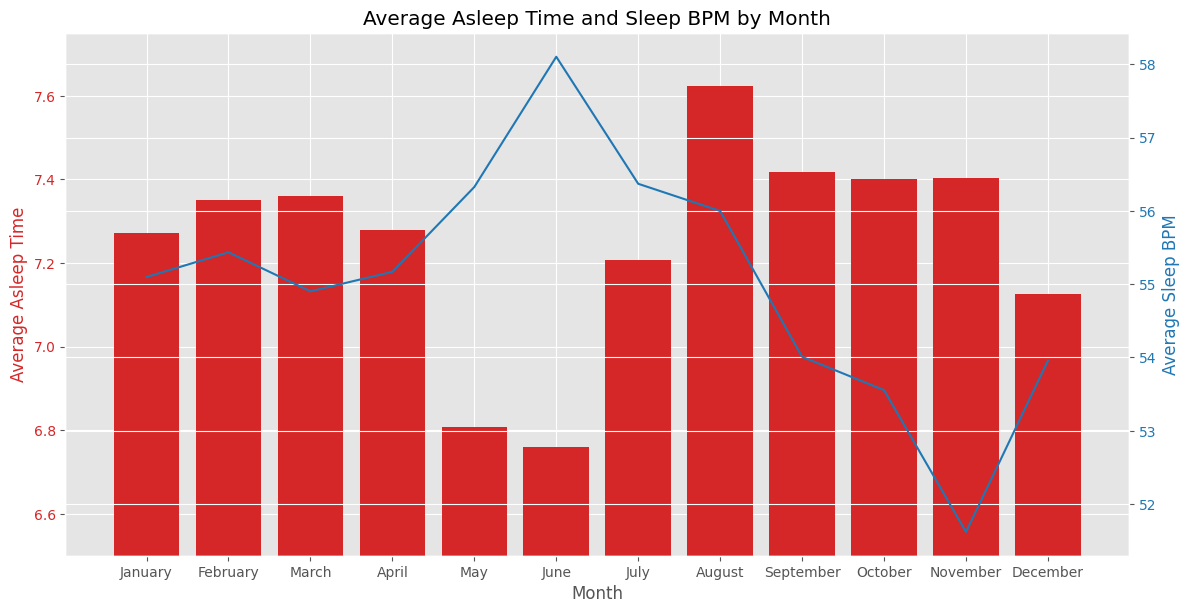

In [ ]:
df['month'] = df['fromDate'].dt.month_name()
df['month'] = pd.Categorical(df['month'], categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered=True)
df['asleep'] = df['asleep'].astype(float)
df['sleepBPM'] = df['sleepBPM'].astype(float)

df_month = df.groupby('month').agg({'asleep': 'mean', 'sleepBPM': 'mean'}).reset_index()
df_month['datapoints'] = df.groupby('month').size().values
for i, v in enumerate(df_month['datapoints']):
    ax1.text(i, v + 6.5, f'n={v}', ha='center', va='bottom', color='black', rotation=90)

fig, ax1 = plt.subplots(figsize=(12,6))

color = 'tab:red'
ax1.set_xlabel('Month')
ax1.set_ylabel('Average Asleep Time', color=color)
ax1.bar(df_month['month'], df_month['asleep'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(6.5, 7.75)  # Set the y-axis limits to only show between 6 and 8

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Average Sleep BPM', color=color)  
ax2.plot(df_month['month'], df_month['sleepBPM'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Average Asleep Time and Sleep BPM by Month')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df_month

,month,asleep,sleepBPM,datapoints
0,January,7.270982,55.098198,112
1,February,7.350667,55.435200,125
2,March,7.359926,54.902941,136
3,April,7.278825,55.168852,122
4,May,6.807492,56.326606,109
5,June,6.760194,58.103883,103
6,July,7.207143,56.370330,91
7,August,7.622348,55.998864,88
8,September,7.418537,54.009184,98
9,October,7.400833,53.554000,100


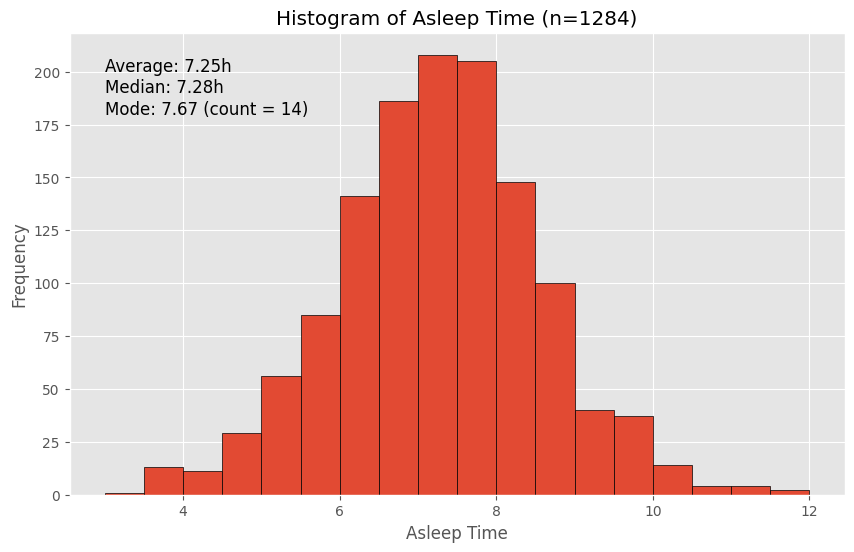

[ 3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.   8.5  9.   9.5
 10.  10.5 11.  11.5 12. ]


In [183]:
plt.figure(figsize=(10,6))
histlen = len(df[(df["asleep"] >= 3) & (df["asleep"] <= 12)])
diff = (12-3)*2
n, bins, patches = plt.hist(df['asleep'], bins=diff, edgecolor='black', range=(3, 12))
plt.text(3, 200, f'Average: {avg("asleep", 2)}h', fontsize=12, ha='left')
plt.text(3, 190, f'Median: {med("asleep", 2)}h', fontsize=12, ha='left')
plt.text(3, 180, f'Mode: {mod("asleep", 2)}', fontsize=12, ha='left')
plt.title(f'Histogram of Asleep Time (n={histlen})')
plt.xlabel('Asleep Time')
plt.ylabel('Frequency')
plt.show()

# Now you can print the values of the bins
print(bins)

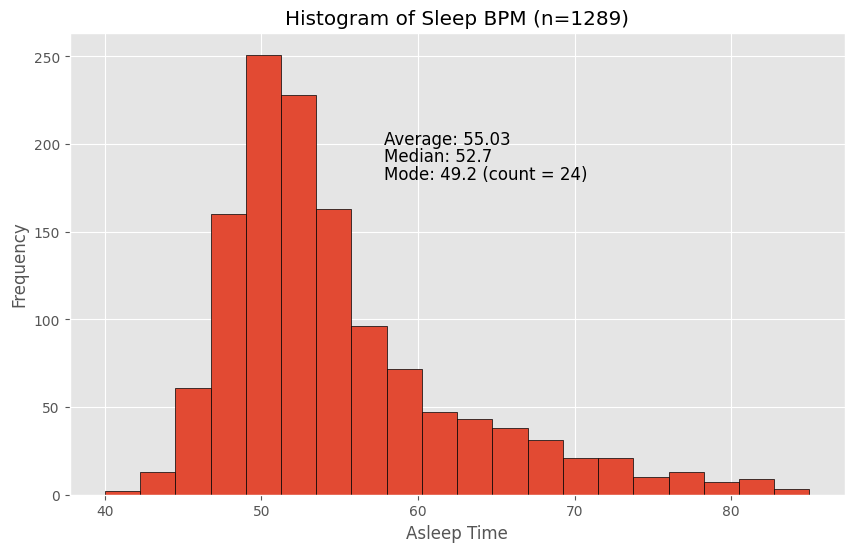

[40.   42.25 44.5  46.75 49.   51.25 53.5  55.75 58.   60.25 62.5  64.75
 67.   69.25 71.5  73.75 76.   78.25 80.5  82.75 85.  ]


In [184]:
df_sleepBPM = df[(df['sleepBPM'] >= 40) & (df['sleepBPM'] <= 85)]


plt.figure(figsize=(10,6))

histlenbpm = len(df_sleepBPM)
# diff = (12-3)*2
t75 = df['sleepBPM'].quantile(0.75)



n, bins, patches = plt.hist(df_sleepBPM['sleepBPM'], bins=20, edgecolor='black', range=(40,85))
plt.text(t75, 200, f'Average: {avg("sleepBPM", 2)}', fontsize=12, ha='left')
plt.text(t75, 190, f'Median: {med("sleepBPM", 2)}', fontsize=12, ha='left')
plt.text(t75, 180, f'Mode: {mod("sleepBPM", 2)}', fontsize=12, ha='left')


plt.title(f'Histogram of Sleep BPM (n={histlenbpm})')
plt.xlabel('Asleep Time')
plt.ylabel('Frequency')
plt.show()

# Now you can print the values of the bins
print(bins)

In [136]:
def med(col, rnd=None):
    return round(df[col].median(), rnd)

def avg(col, rnd=None):
    return round(df[col].mean(), rnd)
from statistics import mode

def mod(col, rnd=None):
    mode_val = mode(df[col])
    mode_count = df[col].tolist().count(mode_val)
    return f"{round(mode_val, rnd)} (count = {mode_count})"


In [145]:
print(f"Average Sleep: {avg('asleep', 2)}h")
print(f"Median Sleep: {med('asleep', 2)}h")
print(f"Mode Sleep: {mod('asleep', 2)}h")
print("----------------------------------------")
print(f"Average Quality Sleep: {avg('quality', 2)}h")
print(f"Median Quality Sleep: {med('quality', 2)}h")
print(f"Mode Quality Sleep: {mod('quality', 2)}h")
print("----------------------------------------")
print(f"Average Deep Sleep: {avg('deep', 2)}h")
print(f"Median Deep Sleep: {med('deep', 2)}h")
print(f"Mode Deep Sleep: {mod('deep', 2)}h")
print("----------------------------------------")
print(f"Average Sleep BPM: {avg('sleepBPM', 2)}")
print(f"Median Sleep BPM: {med('sleepBPM', 2)}")
print(f"Mode Sleep BPM: {mod('sleepBPM', 2)}")
print("----------------------------------------")
print(f"Average Waking BPM: {avg('wakingBPM', 2)}")
print(f"Median Waking BPM: {med('wakingBPM', 2)}")
print(f"Mode Waking BPM: {mod('wakingBPM', 2)}")

Average Sleep: 7.25h
Median Sleep: 7.28h
Mode Sleep: 7.67 (count = 14)h
----------------------------------------
Average Quality Sleep: 5.13h
Median Quality Sleep: 5.17h
Mode Quality Sleep: 5.55 (count = 16)h
----------------------------------------
Average Deep Sleep: 1.87h
Median Deep Sleep: 1.92h
Mode Deep Sleep: 0.0 (count = 84)h
----------------------------------------
Average Sleep BPM: 55.03
Median Sleep BPM: 52.7
Mode Sleep BPM: 49.2 (count = 24)
----------------------------------------
Average Waking BPM: 50.43
Median Waking BPM: 49.0
Mode Waking BPM: 49.0 (count = 137)
